# 3.2. Signal Processing: EKG Data Analysis

#### Understanding Time-Domain Series
1. How to load in and plot series data
2. How to sample data
3. Converting time-series data to the frequency domain
4. Applying filters

---

Let's look at some basic electrocardiograms (EEGs) of a patient. Clinical EKGs are preprocessed and show the typical P, QRS, and T waves, but the raw biopotentials coming from the heart are not as clean.

We'll start by importing the data from a CSV (comma-separated-values) file, using `numpy` and `pandas` again to help us out.

In [1]:
import os
import pandas as pd
import numpy as np

data_directory = "Data/"
filename = "ecg_raw.csv"
filepath = os.path.join(data_directory, filename)

df = pd.read_csv(filepath)

Now let's take a look at what we're working with...

In [2]:
print(df)
num_samples = len(df)
print(f"Number of Samples: {num_samples}")
num_leads = len(df.columns)
print(f"Number of leads: {num_leads}")

          Direct_1   Abdomen_1   Abdomen_2   Abdomen_3   Abdomen_4
0        68.750439   31.149865   53.350204   62.050336   72.550497
1       -39.449737  -80.050356  -53.449950  -44.349811  -30.749604
2       235.303647  191.802983  222.603453  231.803594  248.103843
3      -158.246548 -205.447268 -170.546736 -161.746601 -143.046316
4       157.884878  106.384092  144.784678  152.884802  173.785121
...            ...         ...         ...         ...         ...
299995   41.490142   -3.110539  -13.010690  -12.010674  -12.010674
299996  -77.360485 -120.261139 -129.561281 -128.461264 -129.461280
299997  267.110033  225.009390  216.209256  217.509276  215.709248
299998 -101.385003 -143.285643 -151.785773 -150.185748 -152.285780
299999  191.433040  149.532400  141.132272  142.632295  141.032271

[300000 rows x 5 columns]
Number of Samples: 300000
Number of leads: 5


Just from importing everything from the directory, we have learned a lot: 
1) We have 5 leads
2) The number of samples in each lead (300,000)
3) This dataset does not come with a time domain, the index is 0 through 299,999

If you were to graph this with the given information, it will look very jumbled and would have no meaning

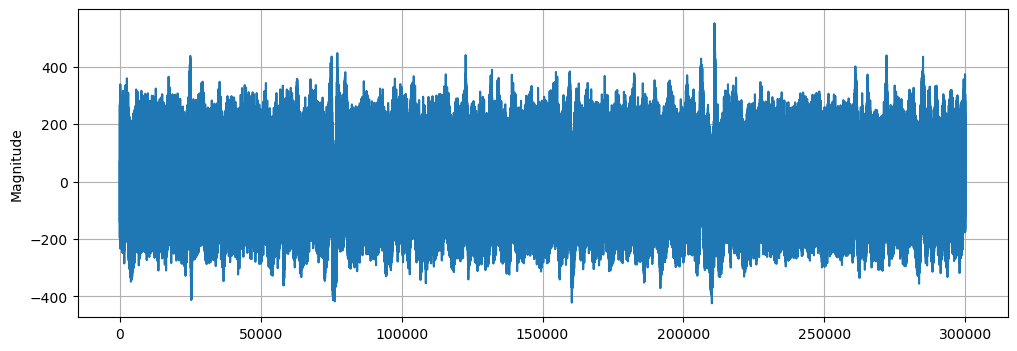

In [3]:
import matplotlib.pyplot as plt
# Access the first column by index
first_column = df.iloc[:, 0]

plt.figure(figsize=(12, 4))
plt.plot(first_column)
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

No matter how good your cardiologist is, I guarantee he won't be able to make anything out of this graph.
Our X-axis is just our sample number, and we still have no clue how the data is sampled.

To make more sense of this, let's use the following metrics...
#### sample_frequency = 1000

This tells us that our input data is taking 1000 samples every second! And if our expected ECG peaks are expected nearly once every second, we now have a frame of reference for what our data represents.

For now, let's just focus on lead 1, which we'll call `data` for now.

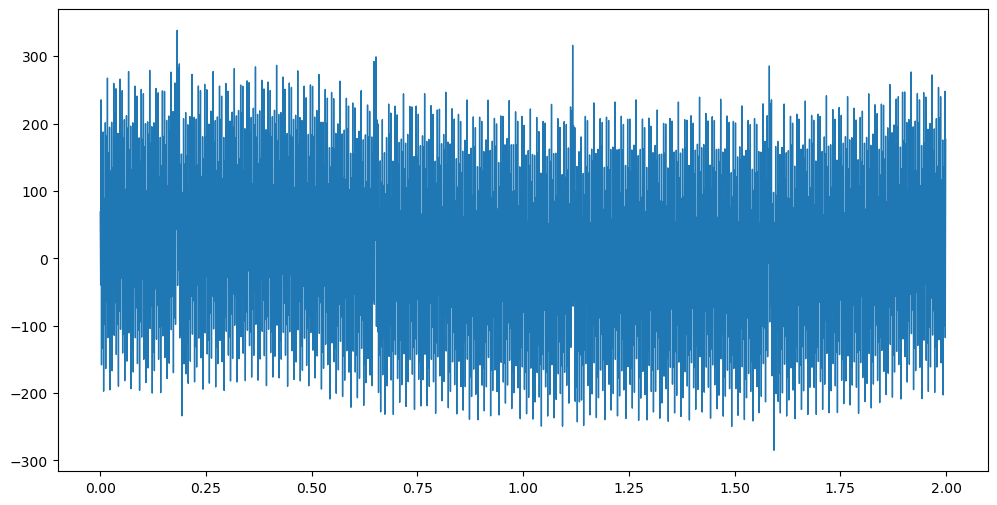

In [4]:
sample_frequency = 1000

data = first_column

time = np.arange(num_samples) / sample_frequency

# Define the time range for plotting (first 2 seconds)
start_time = 0
end_time = 2

start_sample = int(start_time * sample_frequency)
end_sample = int(end_time * sample_frequency)

plt.figure(figsize=(12, 6))
plt.plot(time[start_sample:end_sample], data[start_sample:end_sample], lw=1)
plt.show()

Now this doesn't quite look like your traditional ECG you might see in clinic, but if you hold your breadth and squint your eyes you might begin to see some QRS complexes. Regardless, there seems to be a lot of noise in this signal still.

The big question is how do we know where our signal is versus where the noise is hiding.

A common tool to see if there's noise in a given sample is converting it into the frequency domain.
There's a lot of math behind this, but numpy has a handy function to do it for us

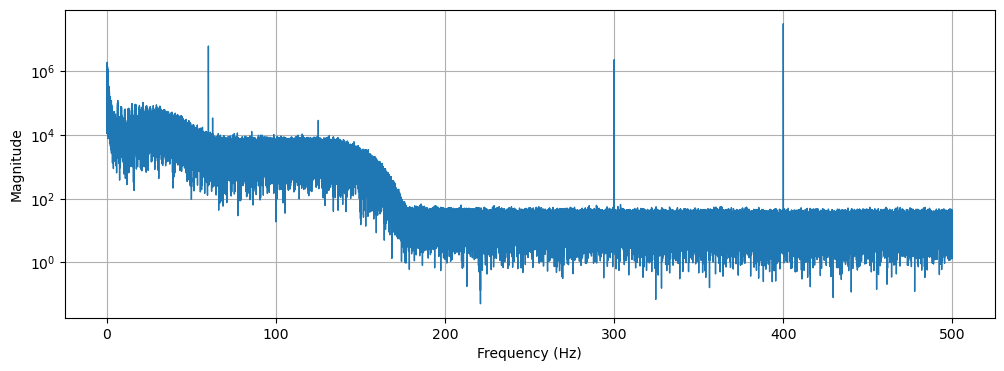

In [5]:
# Perform the Fast Fourier Transform (FFT) to convert to the frequency domain
fft_result = np.fft.fft(data)
frequencies = np.fft.fftfreq(len(fft_result), 1.0 / sample_frequency)

# Plot the magnitude spectrum (positive frequencies)
plt.figure(figsize=(12, 4))
plt.semilogy(frequencies[:num_samples // 2], np.abs(fft_result[:num_samples // 2]), lw=1)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

This may look like a jumbled graph, but it tells us some useful information.
1) Our data seems to be mostly in the low frequencies under 200 Hz
2) We have three odd looking peaks, one at ~60 Hz, one at 300 Hz and one at 400 Hz

This 60 Hz noise is commonly referred to as "mains hum" or "powerline interference" and is typically seen in regions where the electrical power supply operates at a 60 Hz frequency (like in the US).

Let's use something called a notch filter (or a filter that targets only specific frequencies) to get rid of this noise and see what our ECG looks like. For this we need the scipy library

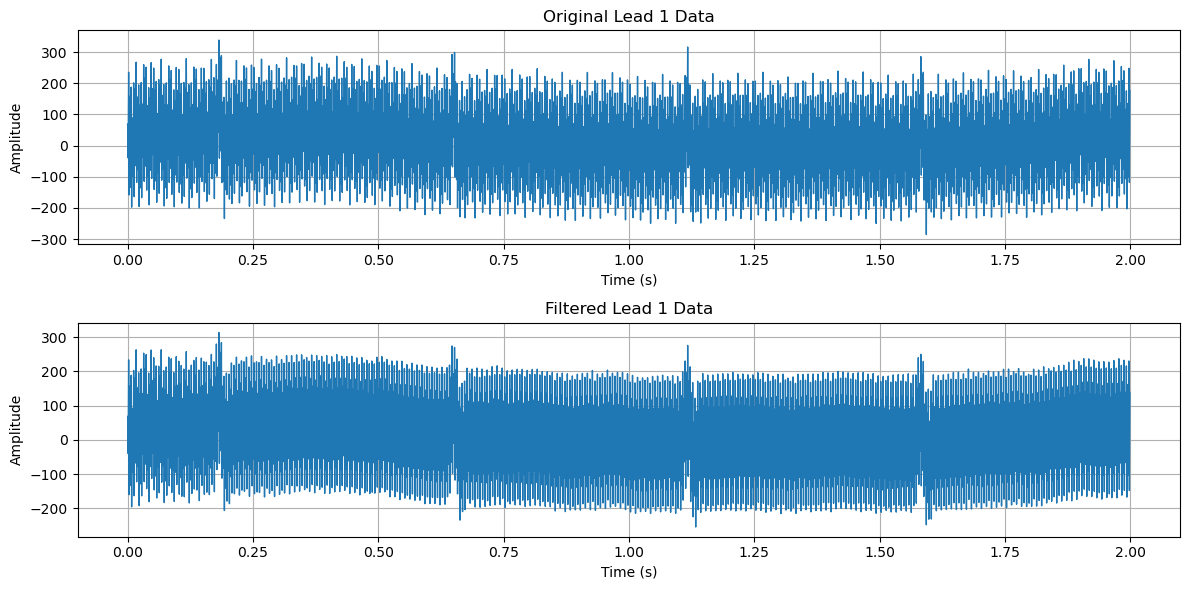

In [6]:
#pip install scipy
from scipy import signal

# Define the notch filter parameters to remove 60 Hz and 120 Hz
center_frequency = 60.0  # Frequencies to be removed (Hz)
Q_factor = 30.0  # Quality factor for the notch filter

# Design the notch filter
b, a = signal.iirnotch(center_frequency, Q_factor, fs=sample_frequency)

# Apply the notch filter to the EKG signal
filtered_lead_data = signal.lfilter(b, a, data)


# Plot the original and filtered EKG signals
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time[start_sample:end_sample], data[start_sample:end_sample], lw=1)
plt.title('Original Lead 1 Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(time[start_sample:end_sample], filtered_lead_data[start_sample:end_sample], lw=1)
plt.title('Filtered Lead 1 Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

Now, let's look at what happened to our frequency spectrogram after applying this notch filter

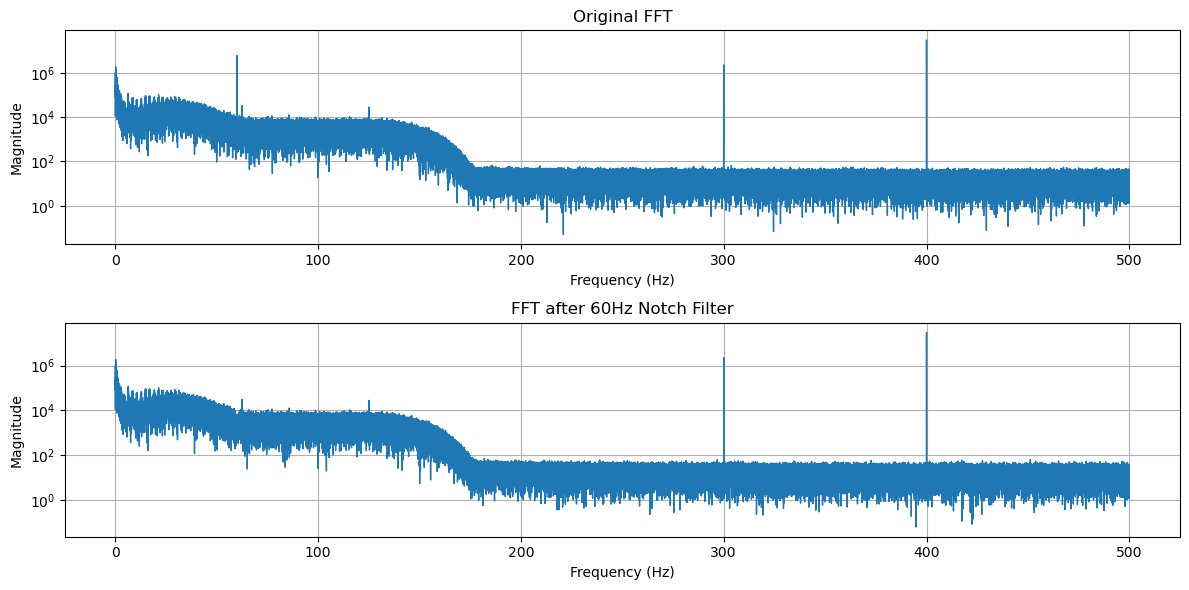

In [7]:
# Plot the original and filtered EKG signals in the frequency domain
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.semilogy(frequencies[:num_samples // 2], np.abs(fft_result[:num_samples // 2]), lw=1)
plt.title('Original FFT')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)

fft_result_60notch = np.fft.fft(filtered_lead_data)
frequencies_60notch = np.fft.fftfreq(len(fft_result_60notch), 1.0 / sample_frequency)

plt.subplot(2, 1, 2)
plt.semilogy(frequencies_60notch[:num_samples // 2], np.abs(fft_result_60notch[:num_samples // 2]), lw=1)
plt.title('FFT after 60Hz Notch Filter')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)

plt.tight_layout()
plt.show()

And just like that, we were able to remove that pesky 60 Hz noise from our sample, and while it still may not look like a traditional ECG, the frequency domain shows us we're moving in the right direction.

We also noticed that most of our signal falls under 200 Hz, so we can do something called a low-band pass filter to just isolate the lower frequencies. In this case, our two big signal noises are coming from 300Hz and 400Hz, so if we want to knock out both with one filter, we can use something caled a low-bandpass filter, which lets through the low-bands (frequencies) while chopping off the higher ones.

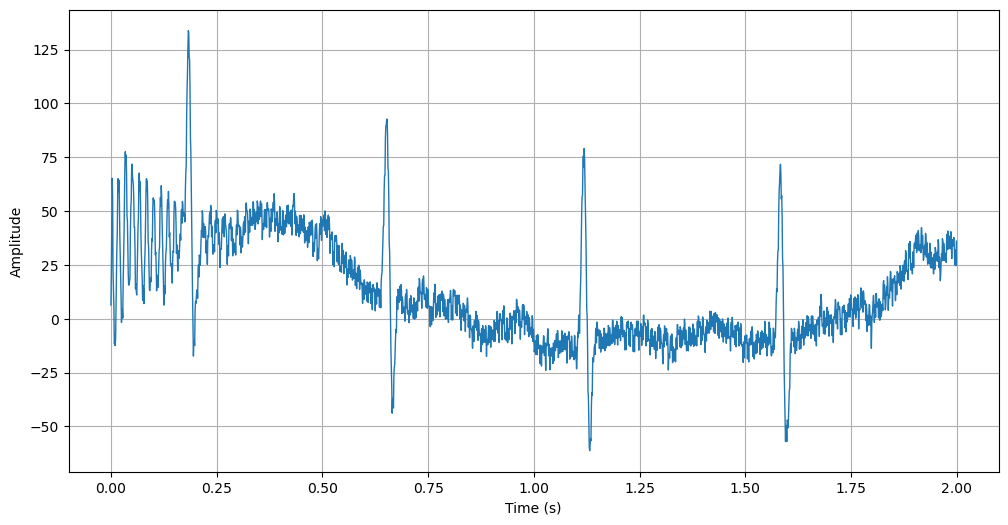

In [8]:
# Define the low-bandpass filter parameters (cutoff frequency under 200 Hz)
cutoff_frequency = 250.0  # Cutoff frequency of the filter (Hz)

# Design the low-bandpass filter
nyquist = 0.5 * sample_frequency
low = cutoff_frequency / nyquist
b, a = signal.butter(4, low, btype='low')

# Apply the low-bandpass filter to the EKG signal
filtered_lead_data2 = signal.lfilter(b, a, filtered_lead_data)

plt.figure(figsize=(12, 6))
plt.plot(time[start_sample:end_sample], filtered_lead_data2[start_sample:end_sample], lw=1)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

Now we have the basis of an ECG, with recognizable QRS complexes and P waves.
We can notice, that the signal seems to "wander" up and down throughout the duraction of the signal.
This is referred to as "Baseline Wander" which usually sits around under 0.5Hz.
To get rid of this source of noise, we'll use a high-bandpass filter to chop our frequencies under 0.5 Hz.

Specifically, we'll use a Finite Impulse Response (FIR) high-pass zero phase forward-backward filter through Scipy

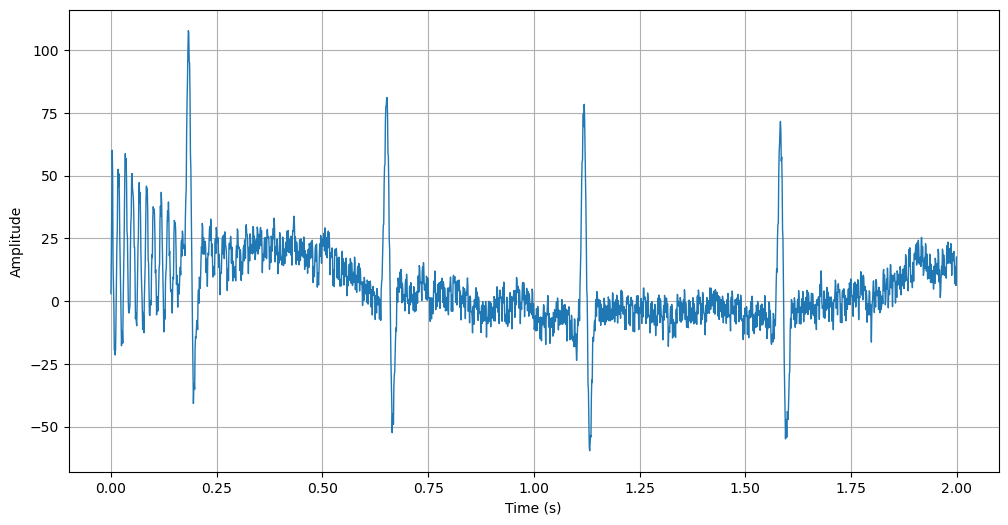

In [9]:
# Define the high-pass filter parameters
cutoff_frequency = 3  # Cutoff frequency (Hz)
filter_order = 101  # Filter order (odd for zero-phase)

# Design the high-pass FIR filter
highpass_filter = signal.firwin(filter_order, cutoff=cutoff_frequency, fs=sample_frequency, pass_zero=False)

# Apply the filter forward and backward to achieve zero-phase filtering
filtered_lead_data3 = signal.filtfilt(highpass_filter, 1, filtered_lead_data2)

plt.figure(figsize=(12, 6))
plt.plot(time[start_sample:end_sample], filtered_lead_data3[start_sample:end_sample], lw=1)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

This didn't make a huge difference, but we have now corrected a little bit of the baseline wandering in the data.

Now, we still have some noise and might want to see our smaller P and T waves more clearly.
To do this we can simply look at a rolling average of our data, which will average the neighboring points with one another to make the series look more smooth.

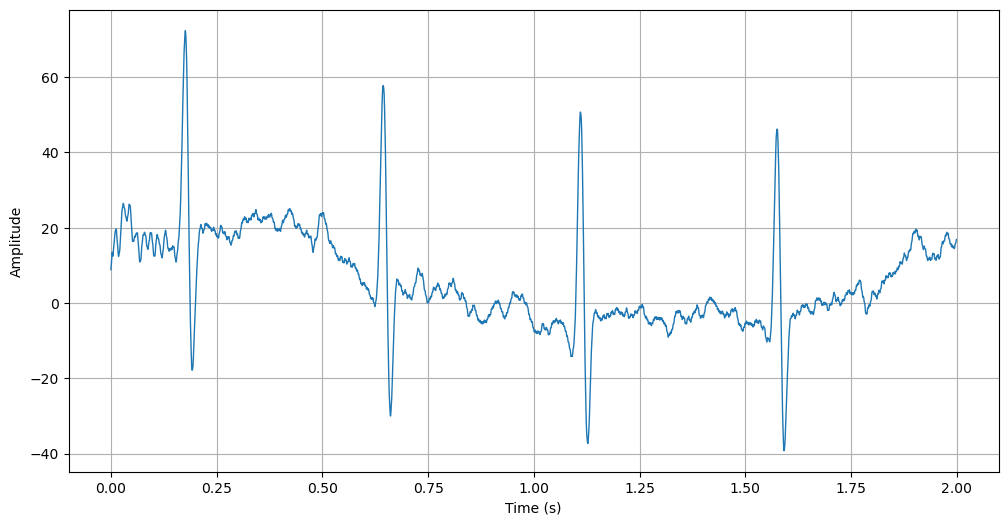

In [10]:
# Rolling window size
window_size = 15

# Create a rolling window kernel
kernel = np.ones(window_size) / window_size

# Use convolution to calculate the rolling average
filtered_lead_data_smoothed = np.convolve(filtered_lead_data3, kernel, mode='valid')


plt.figure(figsize=(12, 6))
plt.plot(time[start_sample:end_sample], filtered_lead_data_smoothed[start_sample:end_sample], lw=1)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

Now, let's bring everything together and apply our filter series to all of the leads and look where our signal processing gets us.
For this, we'll use a for loop for the filters and the graphing.

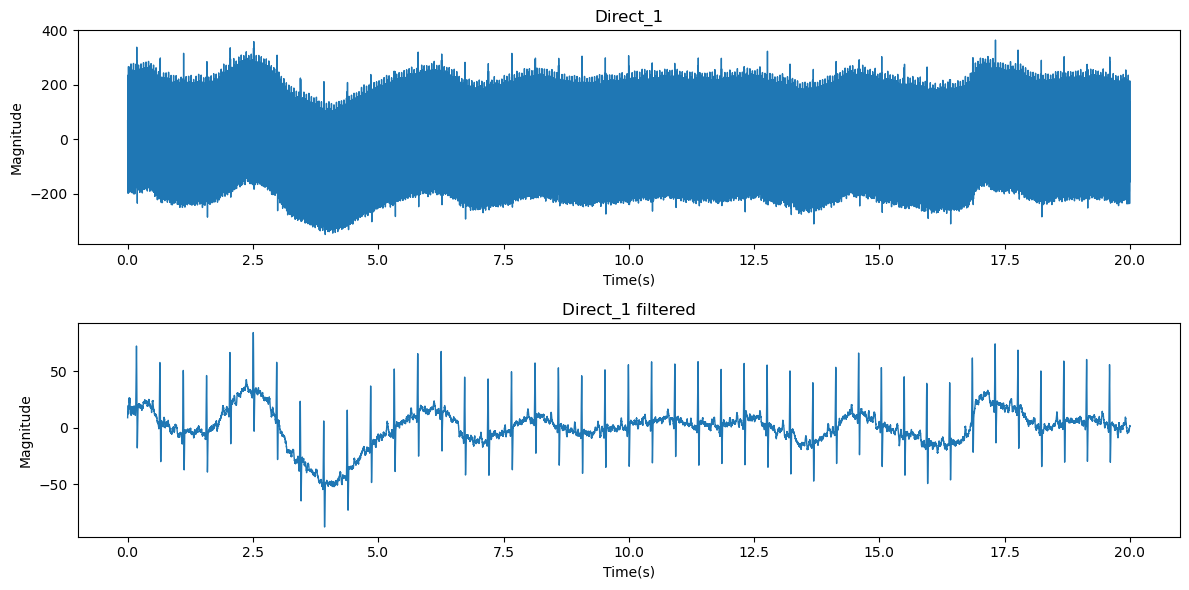

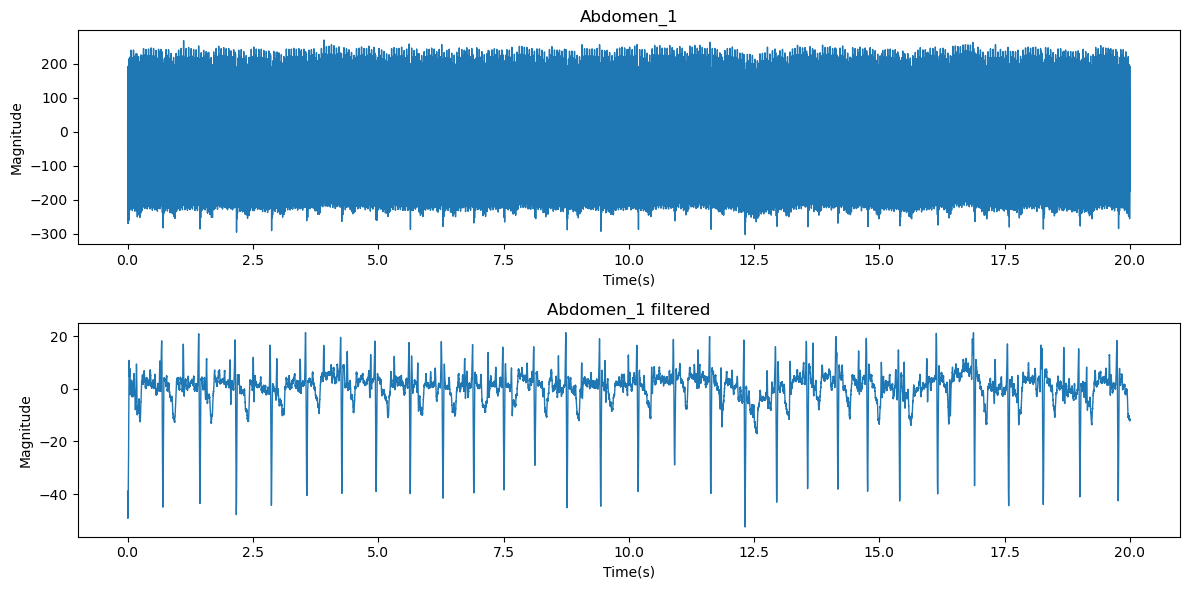

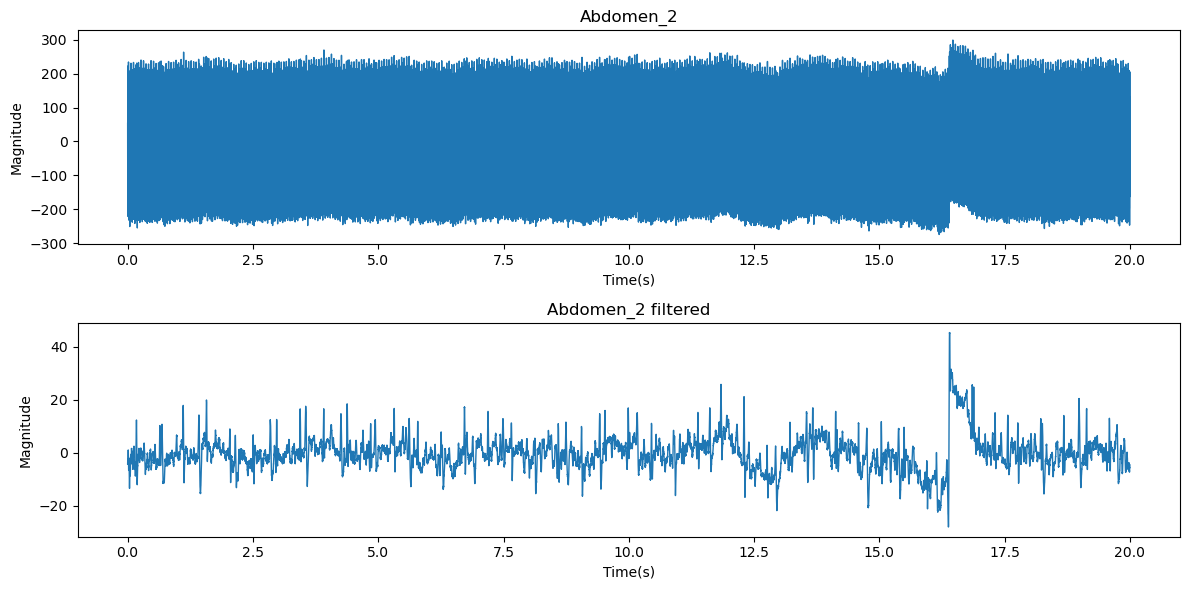

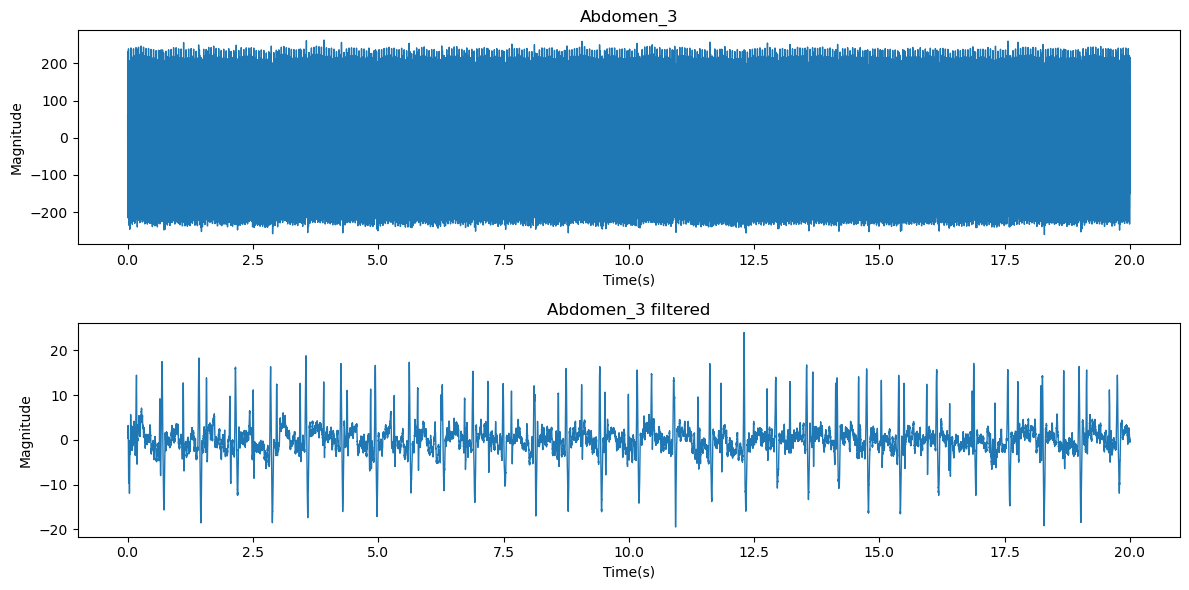

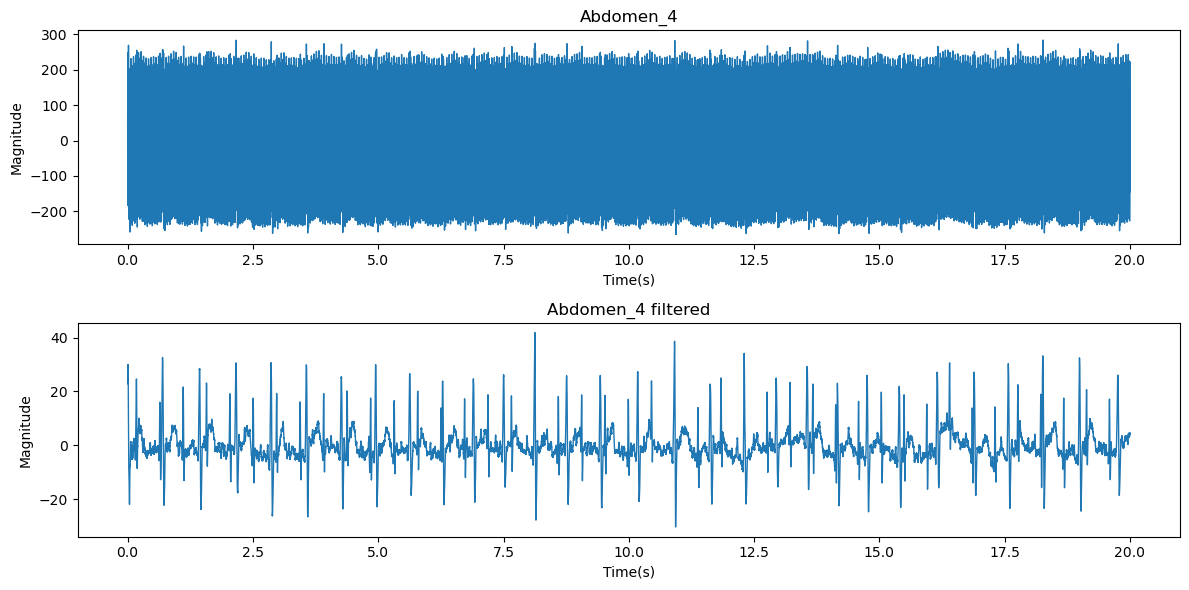

In [11]:
#As a reminder, our full dataset is still saved as df

def apply_filter(data_series, sample_frequency):
    # Define the notch filter to remove 60 Hz 
    center_frequency = 60.0  # Frequencies to be removed (Hz)
    Q_factor = 30.0  # Quality factor for the notch filter
    b, a = signal.iirnotch(center_frequency, Q_factor, fs=sample_frequency)
    filtered_60Hz = signal.lfilter(b, a, data_series)
    
    # Define the low-bandpass filter parameters (cutoff frequency under 250 Hz)
    cutoff_frequency = 250.0 
    nyquist = 0.5 * sample_frequency
    low = cutoff_frequency / nyquist
    b, a = signal.butter(4, low, btype='low')
    filtered_60Hz_LBP250Hz = signal.lfilter(b, a, filtered_60Hz)
    
    # Define the high-pass filter parameters (3 Hz)
    cutoff_frequency = 3 
    filter_order = 101  # Filter order (odd for zero-phase)
    highpass_filter = signal.firwin(filter_order, cutoff=cutoff_frequency, fs=sample_frequency, pass_zero=False)
    filtered_60Hz_LBP250Hz_HBP3Hz = signal.filtfilt(highpass_filter, 1, filtered_60Hz_LBP250Hz)
    
    # Rolling window size 15
    window_size = 15
    kernel = np.ones(window_size) / window_size
    filtered_60Hz_LBP250Hz_HBP3Hz_roll15 = np.convolve(filtered_60Hz_LBP250Hz_HBP3Hz, kernel, mode='valid')
    
    return filtered_60Hz_LBP250Hz_HBP3Hz_roll15

# Define the time range for plotting (first 2 seconds)
start_time = 0
end_time = 20
start_sample = int(start_time * sample_frequency)
end_sample = int(end_time * sample_frequency)


for i in range(len(df.columns)):
    #print(i)
    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 1, 1)
    plt.title(df.columns[i])
    plt.xlabel('Time(s)')
    plt.ylabel('Magnitude')
    #Get 1 column at a time
    data_series = df.iloc[:, i]
    plt.plot(time[start_sample:end_sample], data_series[start_sample:end_sample], lw=1)

    plt.subplot(2, 1, 2)
    plt.title(str(df.columns[i]) + " filtered")
    plt.xlabel('Time(s)')
    plt.ylabel('Magnitude')
    #Apply your combined filters
    filt_data_series=apply_filter(data_series, sample_frequency)
    plt.plot(time[start_sample:end_sample], filt_data_series[start_sample:end_sample], lw=1)

    plt.tight_layout()
    plt.show()

And just like that, we have taken some severely noisy data and turned it into something readible.

A few key take-aways to keep in mind during signal processing
1) Understand your data and sources for noise
2) Filters are great for removing noise, but can also cut off important components of your data as well
3) A signal may never be fully free of noise, the key is removing enough noise until your data is understandable
4) Looking at data in the frequency domain is a powerful tool

## Appendix
An additional challenge is these recordings are typically saved in a non .csv or .json format, which means we'll need to convert the signal before we do anything else. ".dat" or ".edf" are common file types for ecgs but every machine will have it's own unique file type.

Before anything else, you'll need to convert the file into something more familiar to you.

In [13]:
#Luckily, there's a library for reading in ECG .dat formatted files
import pyedflib
import numpy as np
import matplotlib.pyplot as plt

edf_file = "Data/r01.edf"
# Open the .edf file for reading
f = pyedflib.EdfReader(edf_file)

# Get basic information about the recording
num_channels = f.signals_in_file
channel_labels = f.getSignalLabels()
sample_frequency = f.getSampleFrequency(0)  # Sampling frequency of the first channel
num_samples = f.getNSamples()[0]  # Number of samples in the recording

print(num_channels)
print(channel_labels)
print(sample_frequency) 
print(num_samples) 


5
['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']
1000.0
300000


In [14]:
data=f.readSignal(0)

print(data)
print(type(data))

[28.7504387  26.65040665 24.75037766 ... 51.05077897 50.85077592
 50.95077745]
<class 'numpy.ndarray'>


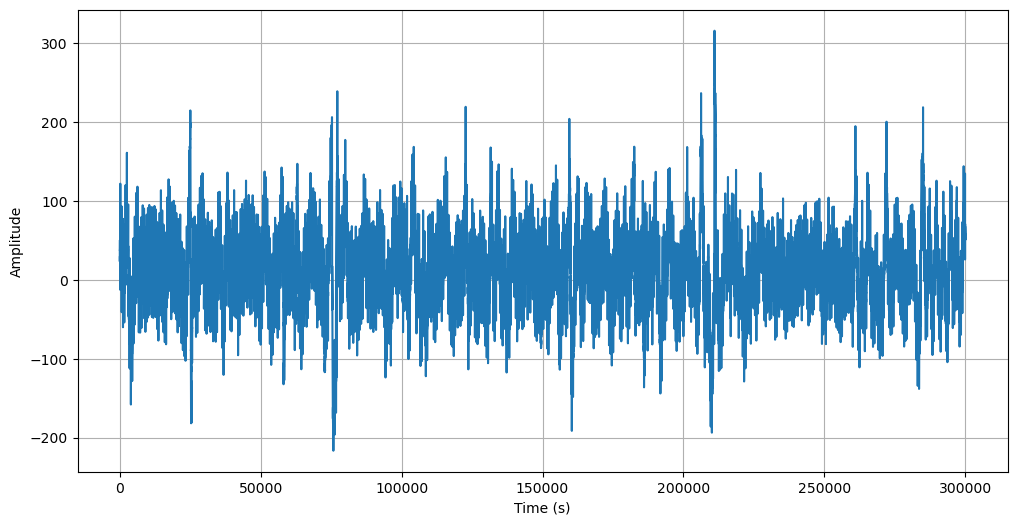

In [15]:
import pyedflib
import numpy as np
# Specify the path to the input .edf file
f.close()
input_file = "Data/r01.edf"

# Open the .edf file for reading
f = pyedflib.EdfReader(input_file)

# Get basic information about the recording
num_channels = f.signals_in_file
channel_labels = f.getSignalLabels()
sample_frequency = f.getSampleFrequency(0)  # Sampling frequency of the first channel

# Read data from the .edf file into a NumPy array
data = np.zeros((num_channels, f.getNSamples()[0]))
for channel in range(num_channels):
    data[channel, :] = f.readSignal(channel)

# Close the .edf file
f.close()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data[0])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

[28.7504387  26.65040665 24.75037766 ... 51.05077897 50.85077592
 50.95077745]


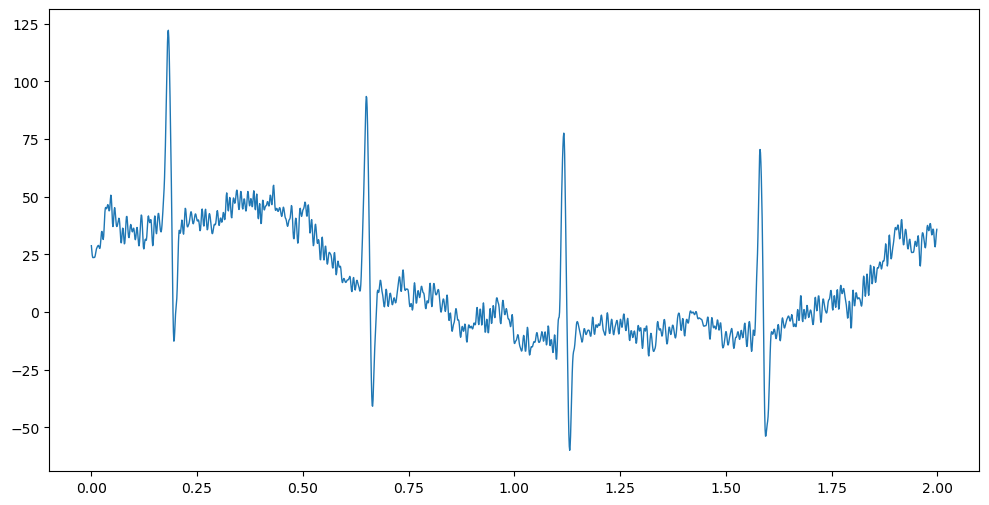

In [16]:
print(data[0])
sample_frequency = 1000
num_samples = 300000 #from above

d = data[0]

time = np.arange(num_samples) / sample_frequency

# Define the time range for plotting (first 2 seconds)
start_time = 0
end_time = 2
start_sample = int(start_time * sample_frequency)
end_sample = int(end_time * sample_frequency)


plt.figure(figsize=(12, 6))
plt.plot(time[start_sample:end_sample], d[start_sample:end_sample], lw=1)
plt.show()

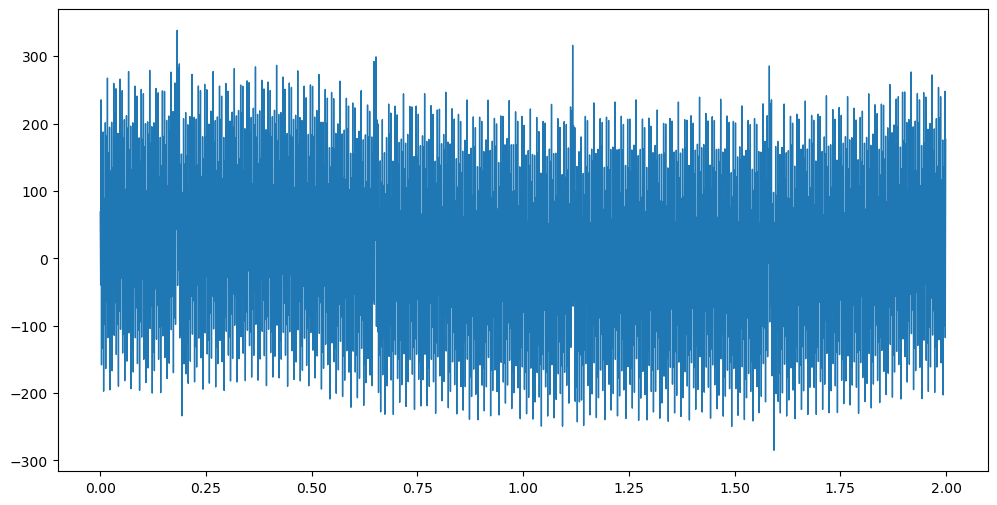

In [17]:
# Create noise signals for 60 Hz and above 200 Hz
# The noise should have the same shape as the original data
t = time
mains_signal = np.cos(2*np.pi*60*t)
over200_signal = np.sin(2*np.pi*300*t)
fake_qrs = 200*np.sin(2*np.pi*600*t)
# Add noise to the original data
noisy_data = d + (40*mains_signal) + (15*over200_signal) + fake_qrs
plt.figure(figsize=(12, 6))
plt.plot(time[start_sample:end_sample], noisy_data[start_sample:end_sample], lw=1)
plt.show()
# Create a new .edf file for the noisy data
output_file = "ecg_noise.edf"
num_samples = data.shape[1]

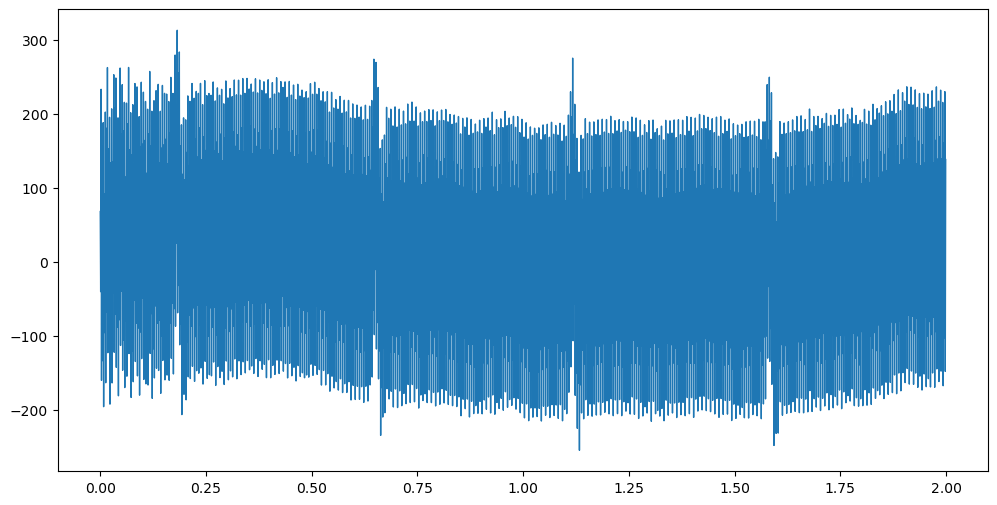

In [18]:
from scipy import signal

# Define the notch filter parameters to remove 60 Hz and 120 Hz
center_frequency = 60.0  # Frequencies to be removed (Hz)
Q_factor = 30.0  # Quality factor for the notch filter

# Design the notch filter
b, a = signal.iirnotch(center_frequency, Q_factor, fs=sample_frequency)

# Apply the notch filter to the EKG signal
filtered_lead_data_1 = signal.lfilter(b, a, noisy_data)
plt.figure(figsize=(12, 6))
plt.plot(time[start_sample:end_sample], filtered_lead_data_1[start_sample:end_sample], lw=1)
plt.show()

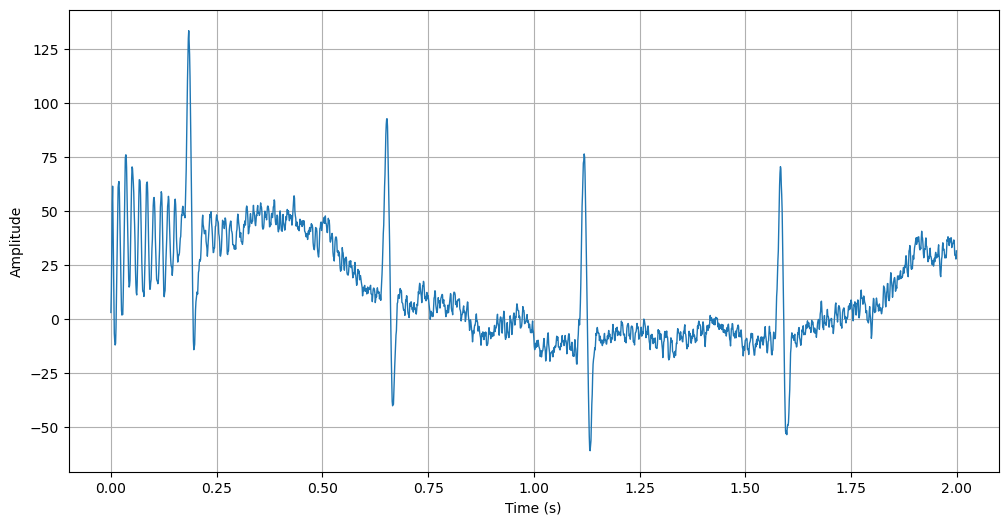

In [19]:
# Define the low-bandpass filter parameters (cutoff frequency under 200 Hz)
cutoff_frequency = 200.0  # Cutoff frequency of the filter (Hz)

# Design the low-bandpass filter
nyquist = 0.5 * sample_frequency
low = cutoff_frequency / nyquist
b, a = signal.butter(4, low, btype='low')

# Apply the low-bandpass filter to the EKG signal
filtered_lead_data2 = signal.lfilter(b, a, filtered_lead_data_1)

plt.figure(figsize=(12, 6))
plt.plot(time[start_sample:end_sample], filtered_lead_data2[start_sample:end_sample], lw=1)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

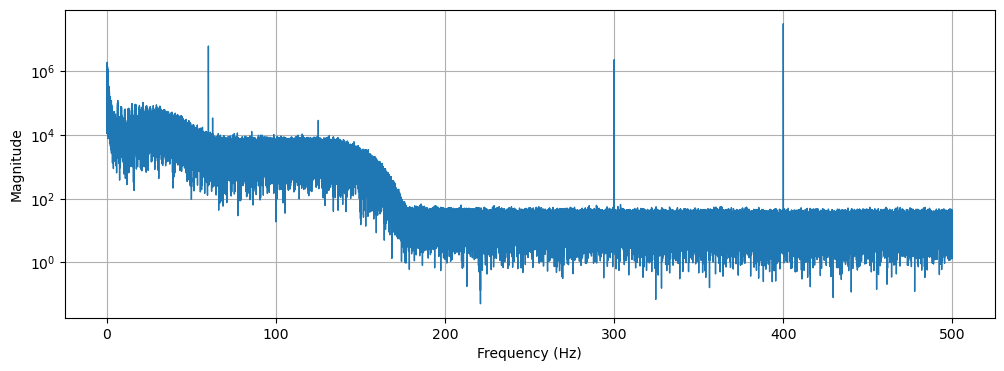

In [20]:
# Perform the Fast Fourier Transform (FFT) to convert to the frequency domain
fft_result = np.fft.fft(noisy_data)
frequencies = np.fft.fftfreq(len(fft_result), 1.0 / sample_frequency)

# Plot the magnitude spectrum (positive frequencies)
plt.figure(figsize=(12, 4))
plt.semilogy(frequencies[:num_samples // 2], np.abs(fft_result[:num_samples // 2]), lw=1)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

In [21]:
import pandas as pd
noisy_df = pd.DataFrame()
channel_labels
i=0
for sub_data in data:
    print(sub_data)
    name = channel_labels[i]
    noisy_df[name] = sub_data +  (40*mains_signal) + (15*over200_signal) + fake_qrs
    i+=1
print(noisy_df.head(5))
noisy_df.to_csv("ecg_raw.csv", index=False)

[28.7504387  26.65040665 24.75037766 ... 51.05077897 50.85077592
 50.95077745]
[ -8.85013504 -13.95021286 -18.75028611 ...   8.95013657   8.95013657
   9.05013809]
[13.35020371 12.65019303 12.05018387 ...  0.15000229  0.45000687
  0.65000992]
[22.05033646 21.75033188 21.25032425 ...  1.45002213  2.05003128
  2.15003281]
[32.55049668 35.35053941 37.55057298 ... -0.35000534 -0.05000076
  0.55000839]
     Direct_1   Abdomen_1   Abdomen_2   Abdomen_3   Abdomen_4
0   68.750439   31.149865   53.350204   62.050336   72.550497
1  -39.449737  -80.050356  -53.449950  -44.349811  -30.749604
2  235.303647  191.802983  222.603453  231.803594  248.103843
3 -158.246548 -205.447268 -170.546736 -161.746601 -143.046316
4  157.884878  106.384092  144.784678  152.884802  173.785121
